In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, roc_auc_score, recall_score, 
    precision_recall_curve, roc_curve, auc, classification_report, 
    confusion_matrix, make_scorer, f1_score, matthews_corrcoef
)
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, cross_val_score, learning_curve, train_test_split
)
from matplotlib.backends.backend_pdf import PdfPages
from itertools import combinations

import joblib
from sklearn.inspection import permutation_importance
from mlxtend.plotting import plot_decision_regions
# Set random seed for reproducibility
np.random.seed(42)
import wandb

In [3]:
import sklearn
print(sklearn.__version__)

1.5.1


# load data

In [112]:
reported_data = pd.read_csv('F:/script/TRIMs/web_pancancer/reported_data.tsv', sep='\t')
reported_data = reported_data[~reported_data['zrank_score'].isna() & reported_data['zrank_score'] != 0]
reported_data['CIV'] = reported_data['group'] == 'CIV'
reported_data['CIV'] = reported_data['CIV'].astype(int)
reported_data = reported_data[~reported_data['TRIM'].isin(['TRIM14', 'TRIM16', 'CMYA5', 'TRIML2'])]
reported_data = reported_data.sample(frac=1, replace=False, random_state=42).sort_values(by=['group'], ascending=True)


In [ ]:
# coding and scale
ms_df = reported_data[reported_data['source'] == 'MS'].reset_index(drop=True)
print("ms_df",len(ms_df['disease'].unique()), len(ms_df),len(ms_df[ms_df['CIV'] == 1]), len(ms_df[ms_df['CIV'] == 0]))
ms_df = ms_df[(ms_df['adj.P.Val'] < 0.01) & (abs(ms_df['logFC']) > 0.5)]
print("MS after logFC cutoff",len(ms_df))

rna_df = reported_data[reported_data['source'] == 'RNAseq'].reset_index(drop=True)
print("rna_df",len(rna_df['disease'].unique()),len(rna_df), len(rna_df[rna_df['CIV'] == 1]), len(rna_df[rna_df['CIV'] == 0]))
rna_df = rna_df[(rna_df['adj.P.Val'] < 0.01) & (abs(rna_df['logFC']) > 1)]
print("RNA after logFC cutoff",len(rna_df))

print(f"Number of duplicate rows:{ms_df.duplicated().sum()},{rna_df.duplicated().sum()}")

# 1. data encoding---------------------------
ms_df = pd.get_dummies(ms_df, columns=['disease']) 
ms_df.iloc[:, -8:] = ms_df.iloc[:, -8:].apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0).astype(int)

rna_df = pd.get_dummies(rna_df, columns=['disease'])
rna_df.iloc[:, -24:] = rna_df.iloc[:, -24:].apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0).astype(int)

# 2. scaling----------------------------
ms_scaler = StandardScaler()
ms_scaler.fit_transform(ms_df[['zrank_score']])
# joblib.dump(ms_scaler, 'F:/script/TRIMs/ML/panmodel/model250416/ms_scaler.pkl')
ms_df[['zrank_score']] = ms_scaler.transform(ms_df[['zrank_score']])
ms_features = ['logFC', 'R', 'zrank_score'] + list(ms_df.columns[-8:])

rna_scaler = StandardScaler()
rna_scaler.fit_transform(rna_df[['zrank_score']])
# joblib.dump(rna_scaler, 'F:/script/TRIMs/ML/panmodel/model250416/rna_scaler.pkl')
rna_df[['zrank_score']] = rna_scaler.transform(rna_df[['zrank_score']])
rna_features = ['logFC', 'R', 'zrank_score'] + list(rna_df.columns[-24:])

ms_df 8 440 233 207
MS after logFC cutoff 339
rna_df 24 4438 2144 2294
RNA after logFC cutoff 1863
Number of duplicate rows:0,0


Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2      1
3      0
5      0
6      0
7      0
      ..
433    0
435    0
436    0
437    1
438    0
Name: disease_EC, Length: 339, dtype: int32' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2      0
3      0
5      0
6      0
7      0
      ..
433    0
435    0
436    0
437    0
438    0
Name: disease_ESCA, Length: 339, dtype: int32' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2      0
3      1
5      0
6      0
7      0
      ..
433    0
435    0
436    0
437    0
438    0
Name: disease_GBM, Length: 339, dtype: int32' has dtype incompatible with bool, please explicitly cast to a compatible dtype first

In [ ]:
np.random.seed(42)
df = rna_df.copy()

print(df['CIV'].value_counts())
#balanced sample
if len(df[df['CIV'] == True]) > len(df[df['CIV'] == False]):
    print("oversample false")
    df_false_sampled = resample(df[df['CIV'] == False], replace=True, n_samples=len(df[df['CIV'] == True]), random_state=42)
    df_balanced = pd.concat([df[df['CIV'] == True], df_false_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
else:
    print("oversample true")
    df_true_sampled = resample(df[df['CIV'] == True], replace=True, n_samples=len(df[df['CIV'] == False]), random_state=42)
    df_balanced = pd.concat([df[df['CIV'] == False], df_true_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

    # print("undersample false")
    # df_false_sampled = resample(df[df['CIV'] == False], replace=False, n_samples=len(df[df['CIV'] == True]), random_state=42)
    # df_balanced = pd.concat([df[df['CIV'] == True], df_false_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['CIV'].value_counts())  

# selected_features = ['logFC', 'R', 'zrank_score'] + list(df_balanced.columns[-8:]) #hot code
selected_features = ['logFC', 'R', 'zrank_score'] + list(df_balanced.columns[-24:])
X = df_balanced[selected_features]
y = df_balanced['CIV']
cv_search = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#candidate models
KNN = KNeighborsClassifier()
NB = GaussianNB()
LDA = LinearDiscriminantAnalysis()
LR = LogisticRegression(random_state=42)
SVM = SVC(random_state=42, probability=True)
RF = RandomForestClassifier(random_state=42)
DT = DecisionTreeClassifier(random_state=42)
models = [DT, RF, NB, LR, LDA,  KNN, SVM]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# X_ms, y_ms = X, y
# X_rna, y_rna = X, y

CIV
0    1024
1     839
Name: count, dtype: int64
oversample true
CIV
1    1024
0    1024
Name: count, dtype: int64


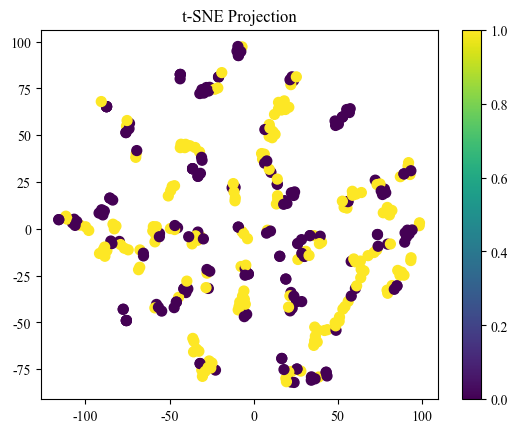

In [54]:
# tsne 可视化数据
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2, perplexity=min(5, len(X)-1)).fit_transform(X)  # 调整perplexity
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar()
plt.title("t-SNE Projection")
plt.savefig("F:/script/TRIMs/ML/panmodel/model250416/hot_ms_tsne.png", dpi=600)
plt.show()


# NB

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Define the parameter grid
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]  # Valid parameter for GaussianNB
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=cv_search, scoring='accuracy')

# Fit the model
grid_search.fit(X, y)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)
best_params_df = pd.DataFrame(grid_search.best_params_, index=[0])
wandb.log({"Best Parameters": wandb.Table(dataframe=best_params_df)})

model = grid_search.best_estimator_

Best Parameters:  {'var_smoothing': 1e-09}


# LR

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=cv_search)
grid_search.fit(X, y)
print(grid_search.best_params_)
best_params_df = pd.DataFrame(grid_search.best_params_, index=[0])
# wandb.log({"Best Parameters": wandb.Table(dataframe=best_params_df)})

model = grid_search.best_estimator_

{'C': 10}


# LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'shrinkage': [None, 'auto', np.linspace(0, 1, 5)]}
grid_search = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv=cv_search, n_jobs=-1)
grid_search.fit(X, y)
print(grid_search.best_params_)
best_params_df = pd.DataFrame(grid_search.best_params_, index=[0])
wandb.log({"Best Parameters": wandb.Table(dataframe=best_params_df)})

model = grid_search.best_estimator_

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv_search)
grid_search.fit(X, y)
print(grid_search.best_params_)
best_params_df = pd.DataFrame(grid_search.best_params_, index=[0])
wandb.log({"Best Parameters": wandb.Table(dataframe=best_params_df)})

model = grid_search.best_estimator_

{'n_neighbors': 3}


# SVM

In [ ]:
# GridSearchCV-CV5
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'C': [0.1, 1],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 0, 4)),
    # 'class_weight': [None, {0: 1, 1: 1.2}]
}
# Initialize the SVM model
svm = SVC(class_weight={0: 1, 1: 1}, probability=True, random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=cv_search, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search.fit(X, y)
print("Best Parameters: ", grid_search.best_params_)
best_params_df = pd.DataFrame(grid_search.best_params_, index=[0])
wandb.log({"Best Parameters": wandb.Table(dataframe=best_params_df)})

# Evaluate the model
model = grid_search.best_estimator_
model.fit(X, y)
# joblib.dump(model, 'F:/script/TRIMs/ML/panmodel/model250416/hot_ms_shuffleCV_svm_gs_model.pkl')

# model estimation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (precision_score, recall_score, accuracy_score, 
                             f1_score, matthews_corrcoef, roc_auc_score, 
                             average_precision_score, confusion_matrix)
n_folds = 5
cv_eval = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=72)
metrics = {
    'Fold': list(range(1, n_folds + 1)),
    'PRE_pos': [], 'PRE_neg': [],
    'SPE': [],
    'REC_pos': [], 'REC_neg': [],  # REC_pos=灵敏度, REC_neg=特异度
    'ACC': [], 'F1_pos': [], 'F1_neg': [],
    'MCC': [], 'AUC': [], 'AUPR': []
}

for fold, (train_idx, test_idx) in enumerate(cv_eval.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    tp, fn, fp, tn = cm.ravel()

    metrics['PRE_pos'].append(precision_score(y_test, y_pred, pos_label=1))
    metrics['PRE_neg'].append(precision_score(y_test, y_pred, pos_label=0))
    metrics['SPE'].append(tn / (tn + fp))
    metrics['REC_pos'].append(recall_score(y_test, y_pred, pos_label=1))
    metrics['REC_neg'].append(recall_score(y_test, y_pred, pos_label=0))
    metrics['ACC'].append(accuracy_score(y_test, y_pred))
    metrics['F1_pos'].append(f1_score(y_test, y_pred, pos_label=1))
    metrics['F1_neg'].append(f1_score(y_test, y_pred, pos_label=0))
    metrics['MCC'].append(matthews_corrcoef(y_test, y_pred))
    metrics['AUC'].append(roc_auc_score(y_test, y_proba))
    metrics['AUPR'].append(average_precision_score(y_test, y_proba))

df_metrics = pd.DataFrame(metrics)
summary_row = {
    'Fold': f'Mean ± Std ({n_folds}-fold CV)',
    **{col: f"{df_metrics[col].mean():.3f} ± {df_metrics[col].std():.3f}" 
       for col in df_metrics.columns if col != 'Fold'}
}


df_final = pd.concat([df_metrics, pd.DataFrame([summary_row])], ignore_index=True).astype(str)
# wandb.log({'cross-validation Estimation': wandb.Table(dataframe=df_final)})
print(model)

# df_final.to_csv('F:/script/TRIMs/ML/panmodel/model250416/hot_rna_shuffleCV_svm_gs_CVestimation.csv', index=False)

In [ ]:
# plot ROC,PR,learning curve without independent test set
pdf_path = 'F:/script/TRIMs/ML/panmodel/model250416/tmp.pdf'
with PdfPages(pdf_path) as pdf:
    # ROC curve-------------------------------
    plt.figure(figsize=(6, 4))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.grid(True)

    # 初始化存储训练集和测试集的ROC曲线数据
    mean_tpr_train = 0.0
    mean_fpr_train = np.linspace(0, 1, 100)
    mean_tpr_test = 0.0
    mean_fpr_test = np.linspace(0, 1, 100)
    tprs_test = []
    aucs_test = []
    tprs_train = []
    aucs_train = []

    for train_index, test_index in cv_eval.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_ = model.fit(X_train, y_train)

        train_probs = model_.predict_proba(X_train)[:, 1]
        fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
        mean_tpr_train += np.interp(mean_fpr_train, fpr_train, tpr_train)
        mean_tpr_train[0] = 0.0
        tprs_train.append(np.interp(mean_fpr_train, fpr_train, tpr_train))
        aucs_train.append(auc(fpr_train, tpr_train))
        
        test_probs = model_.predict_proba(X_test)[:, 1]
        fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
        mean_tpr_test += np.interp(mean_fpr_test, fpr_test, tpr_test)
        mean_tpr_test[0] = 0.0
        tprs_test.append(np.interp(mean_fpr_test, fpr_test, tpr_test))
        aucs_test.append(auc(fpr_test, tpr_test))
        
        plt.plot(fpr_train, tpr_train, color='gray', alpha=0.1)
        plt.plot(fpr_test, tpr_test, color='gray', alpha=0.1)

    mean_tpr_train /= cv_eval.get_n_splits(X, y)
    mean_tpr_train[-1] = 1.0
    mean_auc_train = auc(mean_fpr_train, mean_tpr_train)
    std_auc_train = np.std(aucs_train)
    plt.plot(mean_fpr_train, mean_tpr_train, color='#61aed1', label=f'Mean Train ROC (AUC = {mean_auc_train:.2f} ± {std_auc_train:.2f})')

    mean_tpr_test /= cv_eval.get_n_splits(X, y)
    mean_tpr_test[-1] = 1.0
    mean_auc_test = auc(mean_fpr_test, mean_tpr_test)
    std_auc_test = np.std(aucs_test)
    plt.plot(mean_fpr_test, mean_tpr_test, color='#a161d1', label=f'Mean Test ROC (AUC = {mean_auc_test:.2f} ± {std_auc_test:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random Guess')
    plt.legend(loc='lower right')
    # wandb.log({"ROC_curve": wandb.Image(plt)})
    pdf.savefig()
    plt.show()
    plt.close()
    # PR curve-------------------------------
    plt.figure(figsize=(6, 4))
    plt.title('Precision-Recall (PR) Curve - ')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)

    mean_precision_train = 0.0
    mean_recall_train = np.linspace(0, 1, 100)
    mean_precision_test = 0.0
    mean_recall_test = np.linspace(0, 1, 100)
    precisions_test = []
    aucs_test = []
    precisions_train = []
    aucs_train = []

    for train_index, test_index in cv_eval.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_ = model.fit(X_train, y_train)

        train_probs = model_.predict_proba(X_train)[:, 1]
        precision_train, recall_train, _ = precision_recall_curve(y_train, train_probs)
        mean_precision_train += np.interp(mean_recall_train, recall_train[::-1], precision_train[::-1])
        precisions_train.append(np.interp(mean_recall_train, recall_train[::-1], precision_train[::-1]))
        aucs_train.append(auc(recall_train, precision_train))

        test_probs = model_.predict_proba(X_test)[:, 1]
        precision_test, recall_test, _ = precision_recall_curve(y_test, test_probs)
        mean_precision_test += np.interp(mean_recall_test, recall_test[::-1], precision_test[::-1])
        precisions_test.append(np.interp(mean_recall_test, recall_test[::-1], precision_test[::-1]))
        aucs_test.append(auc(recall_test, precision_test))

        plt.plot(recall_train, precision_train, color='gray', alpha=0.1)
        plt.plot(recall_test, precision_test, color='gray', alpha=0.1)

    # 绘制平均训练集和测试集的PR曲线
    mean_precision_train /= cv_eval.get_n_splits(X, y)
    mean_auc_train = auc(mean_recall_train, mean_precision_train)
    std_auc_train = np.std(aucs_train)
    plt.plot(mean_recall_train, mean_precision_train, color='#61aed1', label=f'Mean Train PR (AUC = {mean_auc_train:.2f} ± {std_auc_train:.2f})')

    mean_precision_test /= cv_eval.get_n_splits(X, y)
    mean_auc_test = auc(mean_recall_test, mean_precision_test)
    std_auc_test = np.std(aucs_test)
    plt.plot(mean_recall_test, mean_precision_test, color='#a161d1', label=f'Mean Test PR (AUC = {mean_auc_test:.2f} ± {std_auc_test:.2f})')

    plt.axhline(y=np.mean(y), color='k', linestyle='--', label='Random Guess')
    plt.legend(loc='lower left')
    wandb.log({"PR_curve": wandb.Image(plt)})
    pdf.savefig()
    plt.show()
    plt.close()
    
    # Learning Curve-------------------------------
    plt.figure(figsize=(6, 4))
    plt.title('Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.grid(True)

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv_eval, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='roc_auc'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color='#61aed1')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='#a161d1')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='#61aed1',
            label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='#a161d1',
            label='Cross-validation score')

    plt.legend(loc='best')
    wandb.log({"Learning Curve": wandb.Image(plt)})
    pdf.savefig()
    plt.show()
    plt.close()

## shap

In [ ]:
import shap
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

sample_data = shap.sample(X, 100, random_state=42)
background = shap.sample(X, 100, random_state=66)

explainer = shap.KernelExplainer(model.predict_proba, background)

shap_values_numpy = explainer.shap_values(sample_data)

100%|██████████| 100/100 [43:32<00:00, 26.13s/it]


In [111]:
# Define the top features
pdf_path = "F:/script/TRIMs/ML/panmodel/model250416/hot_ms_shuffleCV_svm_gs_shap_top3.pdf"
with PdfPages(pdf_path) as pdf:
    top_features = ['logFC', 'R', 'zrank_score']

    # Filter SHAP values to include only the top features
    shap_values_filtered = shap_values_numpy_ms[1][:, [sample_data.columns.get_loc(f) for f in top_features]]

    # Filter sample_data to include only the top features
    sample_data_filtered = sample_data[top_features]

    # Plot the summary plot for the top features
    shap.summary_plot(shap_values_filtered, sample_data_filtered, feature_names=top_features, cmap=plt.cm.BuPu, show=False)
    # shap.summary_plot(shap_values_filtered, sample_data_filtered, feature_names=top_features, cmap=plt.cm.Purples, show=False)
    pdf.savefig()
    plt.close()
    shap.summary_plot(shap_values_filtered, sample_data_filtered, feature_names=top_features, plot_type="bar",color= '#bba1cb', alpha=0.2,show=False) 
    # shap.summary_plot(shap_values_filtered, sample_data_filtered, feature_names=top_features, plot_type="bar",color= '#a4abd6', alpha=0.2,show=False) 
    pdf.savefig()
    plt.close()

In [ ]:
#hap 0.44.1
pdf_path = "F:/script/TRIMs/ML/panmodel/model250416/hot_ms_shuffleCV_svm_gs_shap.pdf"
with PdfPages(pdf_path) as pdf:
    shap.summary_plot(shap_values_numpy[1], sample_data, feature_names=X.columns,
                      cmap=plt.cm.Purples,show=False)
    wandb.log({"SHAP_summary": wandb.Image(plt)})
    pdf.savefig()
    plt.close()

    def bar_color(i):
        colors =  ["#8cb8e1","#1F77B4"]
        return colors[i]
    
    shap.summary_plot(shap_values_numpy, sample_data, feature_names=X.columns, plot_type="bar",
                      color=bar_color, alpha=0.2,show=False) 
    wandb.log({"SHAP_importance": wandb.Image(plt)})
    pdf.savefig()
    plt.close()
    
    for feature in X.columns:
        shap.dependence_plot(feature, shap_values_numpy[0], sample_data, feature_names=X.columns,
                             cmap=plt.cm.BuPu,show=False)
        wandb.log({"SHAP dependence"+feature: wandb.Image(plt)})
        pdf.savefig()
        plt.close()
    
    shap.decision_plot(explainer.expected_value[1], shap_values_numpy[1], sample_data, feature_names=list(X.columns), show=False)
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
    shap.decision_plot(explainer.expected_value[1], shap_values_numpy[1][1], sample_data, feature_names=list(X.columns), show=False)
    pdf.savefig(bbox_inches='tight')
    plt.close()